# Double Deep Q Network for Taxi-v2 environment
We use tf-agents to train Double Deep Q Network for Taxi-v2 environment

## Setup

In [7]:
!apt-get install xvfb
!pip install 'gym==0.10.11'
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay
!pip install tf-agents-nightly
try:
  %%tensorflow_version 2.x
except:
  pass

/bin/sh: apt-get: command not found
  Found existing installation: imageio 2.5.0
Cannot uninstall 'imageio'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [5]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

print(tf.version.VERSION)

2.0.0


In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameter

In [17]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In [12]:
env_name = 'Taxi-v2'
env = suite_gym.load(env_name)
env.reset()
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [13]:
print('Observation Spec:', env.time_step_spec().observation)
print('Reward Spec:', env.time_step_spec().reward)
print('Action Spec:', env.action_spec())

time_step = env.reset()
print('Time step:', time_step)
# When you input integers as action into step argument, you can get the next state
action = 1
next_time_step = env.step(action)
print('Next time step:', next_time_step)

Observation Spec: BoundedArraySpec(shape=(), dtype=dtype('int64'), name='observation', minimum=0, maximum=499)
Reward Spec: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec: BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)
Time step: TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array(254))
Next time step: TimeStep(step_type=array(1, dtype=int32), reward=array(-1., dtype=float32), discount=array(1., dtype=float32), observation=array(154))


In [14]:
# This is python environment
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# But to run tf-agents, we need to convert to tensorflow environment
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent
When we want to build neural network, we use tf_agents.networks.q_network.QNetwork.
<br>
When we want to build double Deep Q Network, we use tf_agents.agents.dqn.dqn_agent.DdqnAgent

In [18]:
# 1 layer 100 nodes
fc_layer_params = (100,)

# The below only set 1 hidden layer, which is 100 nodes densely connected layer
# adding other arguments to build neural network
q_net = q_network.QNetwork(
    # input_tensor_spec (DQN input is state)
    train_env.observation_spec(),
    # action_spec (DQN output is action)
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [20]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DdqnAgent(
    # time_step_spec (something containing state and reward)
    train_env.time_step_spec(),
    # action_spec
    train_env.action_spec(),
    # q_network should be developed in advance, No default value
    q_network=q_net,
    # optimizer does not have default value
    optimizer=optimizer,
    # td_errors_loss_fn, default is element_wise_huber_loss, this example plays around this loss function
    td_errors_loss_fn=common.element_wise_squared_loss,
    # counter for training
    train_step_counter=train_step_counter)

agent.initialize()

In [21]:
print(train_env.time_step_spec())
print("agent._epsilon_greedy", agent._epsilon_greedy)
print("agent._optimizer", agent._optimizer)
print("agent._initialize", agent._initialize)

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(), dtype=tf.int64, name='observation', minimum=array(0), maximum=array(499)))
agent._epsilon_greedy 0.1
agent._optimizer <tensorflow.python.training.adam.AdamOptimizer object at 0x1a2a4d5358>
agent._initialize <bound method DqnAgent._initialize of <tf_agents.agents.dqn.dqn_agent.DdqnAgent object at 0x1a2a4d57b8>>


## Policy

In [22]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [23]:
print("agent.policy", agent.policy)
print("agent.collect_policy", agent.collect_policy)
# So the default setting of collect_policy is epsilon greedy policy, so use exploration and exploitation
# But for evaluation, we already have optimal policy, we only use greedy policy to follow our optimal policy
# In evaluation, we don't need to explore by epsilon because it is not training.

agent.policy <tf_agents.policies.greedy_policy.GreedyPolicy object at 0x1a2a586c18>
agent.collect_policy <tf_agents.policies.epsilon_greedy_policy.EpsilonGreedyPolicy object at 0x1a2a5862b0>


In [24]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
# RandomTFPolicy has _uniform_probability function inside
# By using maximum action index minus minimum action index, it returns uniform distribution

## Metrics and evaluation

In [25]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      # Do not use the below. It use tensor objects which cause error
      # time_step = environment.step(action_step.action)
      # For step argument, we put numpy object as action integer like below
      time_step = eval_env.step(action_step.action.numpy()[0])
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [26]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-794.9

## Replay buffer

In [27]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [28]:
print(agent.collect_data_spec)
print(agent.collect_data_spec._fields)

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(), dtype=tf.int64, name='observation', minimum=array(0), maximum=array(499)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))
('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


## Data collection

In [29]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  # Do not use the below. It use tensor objects which cause error
  # next_time_step = environment.step(action_step.action)
  # For step argument, we put numpy object as action integer like below
  next_time_step = environment.step(action_step.action.numpy()[0])
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

In [30]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
dataset

<DatasetV1Adapter shapes: (Trajectory(step_type=(64, 2), observation=(64, 2), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.int64, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [31]:
iterator = iter(dataset)
print(iterator)

## Training the agent
The below program performs training with the number of num_iterations training, which is set in the Hyperparameter section.

In [43]:
#@test {"skip": true}
#%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 213795176448.0
step = 400: loss = 18826885120.0
step = 600: loss = 124545384448.0
step = 800: loss = 81646362624.0
step = 1000: loss = 187360854016.0
step = 1000: Average Return = -200.0
step = 1200: loss = 159772934144.0
step = 1400: loss = 14532604928.0
step = 1600: loss = 295750303744.0
step = 1800: loss = 77805101056.0
step = 2000: loss = 93568884736.0
step = 2000: Average Return = -200.0
step = 2200: loss = 324784685056.0
step = 2400: loss = 202084777984.0
step = 2600: loss = 398303887360.0
step = 2800: loss = 425610510336.0
step = 3000: loss = 178233180160.0
step = 3000: Average Return = -200.0
step = 3200: loss = 51315331072.0
step = 3400: loss = 331902812160.0
step = 3600: loss = 529813635072.0
step = 3800: loss = 202497261568.0
step = 4000: loss = 545513177088.0
step = 4000: Average Return = -200.0
step = 4200: loss = 12434911232.0
step = 4400: loss = 576582057984.0
step = 4600: loss = 224522338304.0
step = 4800: loss = 230520799232.0
step = 5000: loss = 335

## Visualization

Text(0.5, 0, 'Iterations')

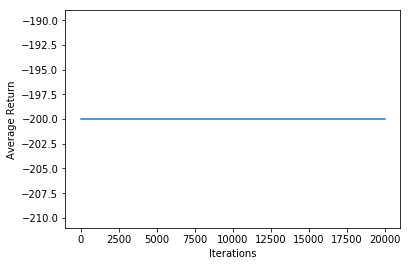

In [44]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=-100)

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [42]:
eval_py_env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


In [37]:
agent.policy